In [1]:
import random
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import functional as F
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModel

## Setup

In [2]:
# Set images path
train_path = Path("../data/BrainTumor/train")
test_path = Path("../data/BrainTumor/test")
valid_path = Path("../data/BrainTumor/valid")

# Setup class names
CLASSES_NAMES = ["glioma", "meningioma", "pituitary"]

# Define datasets
datasets = {"Train": train_path, "Test": test_path, "Validation": valid_path}

# Load Dinov2 model and transformer
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base", use_fast=True)
dinov2 = AutoModel.from_pretrained("facebook/dinov2-base")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
class CustomDataset(Dataset):
    """Simplified Dataset for object detection"""

    def __init__(self, directory: Path, processor=None) -> None:
        """
        Args:
            directory: Path to images and labels folder
            processor: Image processor (DINOv2 processor)
        """
        super().__init__()
        self.images_dir = directory / "images"
        self.labels_dir = directory / "labels"
        self.processor = processor

        # Get all image files
        self.image_files = list(self.images_dir.glob("*.jpg"))
        self.image_files.sort()

        print(f"Found {len(self.image_files)} images in {self.images_dir}")

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx) -> Dict[str, Any]:
        img_path = self.image_files[idx]
        image = Image.open(img_path)

        label_path = self.labels_dir / f"{img_path.stem}.txt"
        labels = self._load_labels(label_path)

        # Process image
        if self.processor:
            processed_image = self.processor(images=image, return_tensors="pt")
            pixel_values = processed_image["pixel_values"].squeeze(0)
        else:
            pixel_values = image

        return {"pixel_values": pixel_values, "labels": labels, "image_path": str(img_path), "original_image": image}

    def _load_labels(self, labels_path: Path) -> List[Dict[str, Any]]:
        """Load labels from text file"""
        labels = []

        with open(labels_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            entries = line.strip().split()
            # Extract class id (first entry)
            class_id = int(entries[0])

            # Extract polygon coordinates
            coordinates = [float(i) for i in entries[1:]]
            x_coords = coordinates[::2]
            y_coords = coordinates[1::2]

            # Get bounding box from polygon vertices
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            # Convert to center format
            cx = (x_min + x_max) / 2
            cy = (y_min + y_max) / 2
            width = x_max - x_min
            height = y_max - y_min

            labels.append(
                {"class_id": class_id, "bbox": [cx, cy, width, height], "vertices": list(zip(x_coords, y_coords))}
            )

        return labels

In [4]:
def create_dataloaders(
    train_dir: Path, test_dir: Path, processor, batch_size: int = 16
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = CustomDataset(train_dir, processor)
    test_dataset = CustomDataset(test_dir, processor)

    def collate_fn(batch) -> Dict[str, Any]:
        """Custom collate function to handle variable number of labels"""
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        labels = [item["labels"] for item in batch]
        image_paths = [item["image_path"] for item in batch]
        original_images = [item["original_image"] for item in batch]

        return {
            "pixel_values": pixel_values,
            "labels": labels,
            "image_paths": image_paths,
            "original_images": original_images,
        }

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_dataloader, test_dataloader

In [5]:
# Create train and test dataloaders
train_dataloader, test_dataloader = create_dataloaders(
    train_dir=train_path,
    test_dir=test_path,
    processor=processor,
    batch_size=16,
)

Found 2144 images in ../data/BrainTumor/train/images
Found 308 images in ../data/BrainTumor/test/images


Testing DataLoader...
Batch shape: torch.Size([16, 3, 224, 224])
Original images shape: [640, 640]


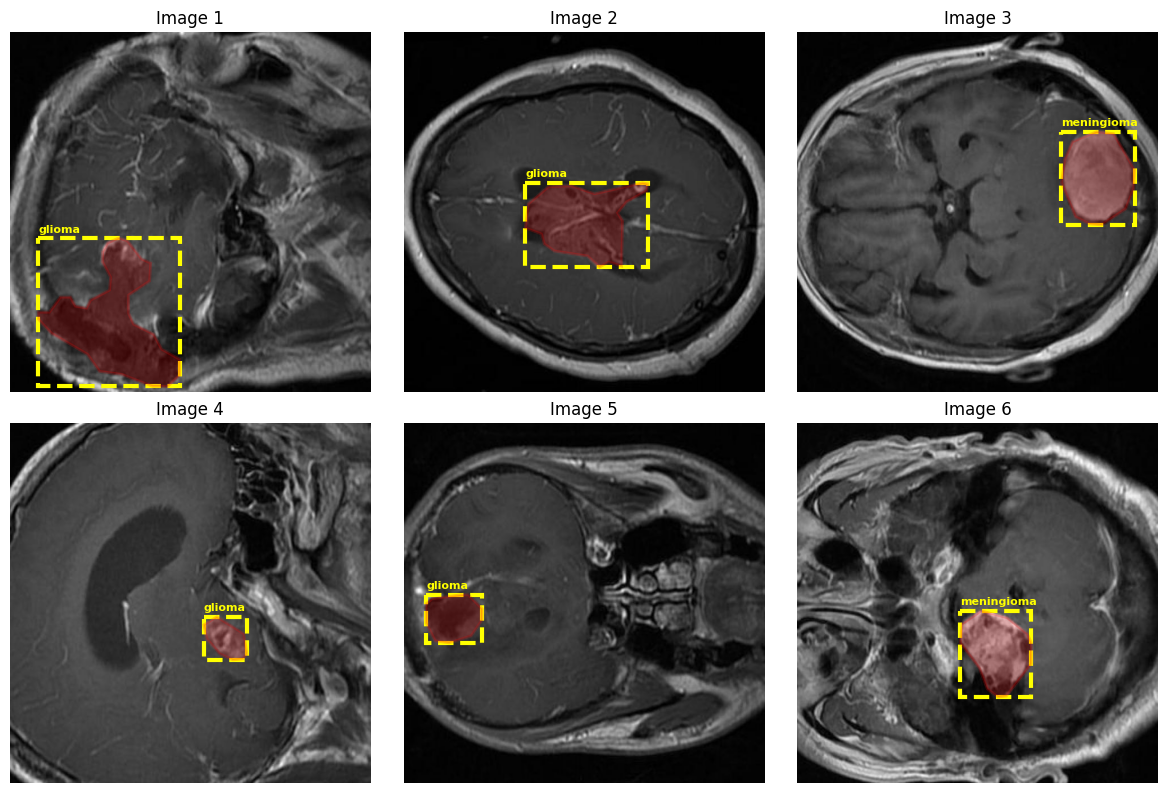

In [16]:
def visualize_batch(dataloader, num_samples=6) -> None:
    """Visualize a batch of images with YOLO bounding boxes"""

    # Get one batch
    batch = next(iter(dataloader))

    pixel_values = batch["pixel_values"]
    labels_list = batch["labels"]
    original_images = batch["original_images"]

    print(f"Batch shape: {pixel_values.shape}")
    print(f"Original images shape: {F.get_size(original_images[0])}")

    # Plot images with bounding boxes
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(min(num_samples, len(original_images))):
        ax = axes[i]
        image = original_images[i]
        labels = labels_list[i]
        img_width, img_height = F.get_size(image)

        # Display image
        ax.imshow(image)
        ax.set_title(f"Image {i + 1}")
        ax.axis("off")

        # Draw bounding boxes
        for label in labels:
            bbox = label["bbox"]
            polygon_points = label["vertices"]
            class_id = label["class_id"]

            # Create rectangle patch
            cx, cy, width, height = bbox

            # Scale to image size
            cx, cy, width, height = cx * img_width, cy * img_height, width * img_width, height * img_height
            polygon_points = [(x * img_width, y * img_height) for x, y in polygon_points]

            # Convert to corner format
            x_min = cx - width / 2
            y_min = cy - height / 2

            # Draw both polygon and bounding box
            rect = patches.Rectangle(
                (x_min, y_min), width, height, linewidth=3, edgecolor="yellow", facecolor="none", linestyle="--"
            )
            polygon = patches.Polygon(
                polygon_points, linewidth=2, edgecolor="red", facecolor="red", alpha=0.2, closed=True
            )
            ax.add_patch(rect)
            ax.add_patch(polygon)

            # Add class label
            ax.text(x_min, y_min - 10, f"{CLASSES_NAMES[class_id]}", color="yellow", fontsize=8, fontweight="bold")

    plt.tight_layout()
    plt.show()


# Test the dataloader
print("Testing DataLoader...")
visualize_batch(train_dataloader)

## Modify Base Model for Object Detection:

In [19]:
class ObjectDetectorWrapper(nn.Module):
    """DINO model with object detection heads"""

    def __init__(
        self,
        model,
        num_classes: int = 3,
        num_patches: int = 256,
        head_dropout: float = 0.1,
        head_hidden_dim: int = 196,
    ) -> None:
        super().__init__()
        self.head_dropout = head_dropout
        self.head_hidden_dim = head_hidden_dim
        self.backbone = model
        self.num_patches = num_patches
        self.embed_dim = model.config.hidden_size

        # Class head (Patch contains a class) [batch, num_patches, embed_dim] -> [batch, num_patches, num_classes+1]
        self.class_head = nn.Sequential(
            nn.Linear(self.embed_dim, self.head_hidden_dim),
            nn.LayerNorm(self.head_hidden_dim),
            nn.ReLU(),
            nn.Dropout(self.head_dropout),
            nn.Linear(self.head_hidden_dim, num_classes + 1),  # +1 for background/no object
        )

        # Bounding box head (Patch bounding box) [batch, num_patches, embed_dim] -> [batch, num_patches, 4]
        self.bbox_head = nn.Sequential(
            nn.Linear(self.embed_dim, self.head_hidden_dim),
            nn.LayerNorm(self.head_hidden_dim),
            nn.ReLU(),
            nn.Dropout(self.head_dropout),
            nn.Linear(self.head_hidden_dim, 4),  # cx, cy, w, h
        )

        # Objectness head (Patch contains an object or not) [batch, num_patches, embed_dim] -> [batch, num_patches, 1]
        self.objectness_head = nn.Sequential(
            nn.Linear(self.embed_dim, self.head_hidden_dim // 2),
            nn.LayerNorm(self.head_hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(self.head_hidden_dim // 2, 1),
        )

    def forward(self, pixel_values: torch.Tensor) -> Dict[str, torch.Tensor]:
        # Extract features from model
        outputs = self.backbone(pixel_values)
        patch_embeddings = outputs.last_hidden_state[:, 1:, :]  # Remove CLS token

        # Apply detection heads to each patch
        class_logits = self.class_head(patch_embeddings)  # [batch, num_patches, num_classes+1]
        bbox_preds = self.bbox_head(patch_embeddings)  # [batch, num_patches, 4]
        objectness = self.objectness_head(patch_embeddings)  # [batch, num_patches, 1]

        return {
            "class_logits": class_logits,
            "bbox_preds": bbox_preds,
            "objectness": objectness.squeeze(-1),  # [B, num_patches]
        }


In [20]:
dinov2_object_detector = ObjectDetectorWrapper(dinov2, num_classes=len(CLASSES_NAMES), num_patches=256)
dinov2_object_detector.eval()
with torch.inference_mode():
    outputs = dinov2_object_detector(torch.randn(1, 3, 224, 224))
print(f"Class Logits: {outputs['class_logits'].shape}")
print(f"Bounding Box Predictions: {outputs['bbox_preds'].shape}")
print(f"Objectness: {outputs['objectness'].shape}")

Class Logits: torch.Size([1, 256, 4])
Bounding Box Predictions: torch.Size([1, 256, 4])
Objectness: torch.Size([1, 256])


In [21]:
outputs["class_logits"]  # [batch size: 1, num_patches: 256, num_classes: 4 (3 classes + 1 background)]

tensor([[[ 0.1526, -0.0579,  0.8695, -0.3962],
         [-0.4730, -0.3196,  0.9151, -0.0034],
         [-0.3658, -0.2129,  0.6012, -0.2947],
         ...,
         [-0.1888, -0.1072,  0.6136, -0.1322],
         [-0.3276, -0.2191,  0.6951, -0.1208],
         [-0.3162,  0.0762,  0.3929, -0.3650]]])

In [22]:
outputs["bbox_preds"]  # [batch size: 1, num_patches: 256, bounding box: (cx, cy, w, h)]

tensor([[[ 0.6944,  0.0169,  0.3209,  0.4687],
         [ 0.8445, -0.4332, -0.0037,  0.3498],
         [ 0.5954, -0.3722, -0.1499,  0.5668],
         ...,
         [ 0.6385, -0.8268, -0.2140,  0.4542],
         [ 0.6515, -0.6872, -0.3011,  0.3166],
         [ 0.7018, -0.7763, -0.2692,  0.5740]]])

In [23]:
outputs["objectness"]  # [batch size: 1, num_patches: 256]

tensor([[-0.3760, -0.3038, -0.7306, -0.0931, -0.2995, -0.3795, -0.7144,  0.0390,
         -0.0840, -0.5298, -0.1892, -0.4165, -0.0663, -0.4419, -0.0269, -0.5196,
         -0.8292, -0.5384, -0.4365, -0.4631, -0.4676, -0.2011, -0.5802, -0.4550,
         -0.4736, -0.5084, -0.4456, -0.5467, -0.2928, -0.3045, -0.4085, -0.4527,
         -1.0050, -0.6410, -0.5023, -0.4587, -0.4471, -0.5007, -0.0988, -0.5858,
         -0.5309, -0.4346, -0.0437, -0.5692, -0.5104, -0.1257, -0.4953, -0.8951,
         -0.6606, -0.6320, -0.6012, -0.3265, -0.3651, -0.5374, -0.5151, -0.2924,
         -0.4910, -0.4288, -0.3054, -0.3549, -0.4052, -0.1884, -0.4802, -0.4711,
         -1.0799, -0.6104, -0.6030, -0.5988, -0.5606, -0.5787, -0.0883, -0.3722,
         -0.4404, -0.3515, -0.4088, -0.4442, -0.5636, -0.5433, -0.5620, -0.7407,
         -1.0824, -0.7336, -0.5340, -0.4330, -0.6281, -0.5283, -0.4218, -0.1283,
         -0.4724, -0.5144, -0.5345, -0.4630, -0.4180, -0.3639, -0.5808, -0.6707,
         -1.0349, -0.8875, -

## Modify targets for prediction:

In [24]:
def prepare_targets(
    labels_batch, image_size: Tuple[int, int] = (224, 224), patch_size: int = 14
) -> Dict[str, torch.Tensor]:
    """
    Convert labels to patch-level targets
    """
    batch_size = len(labels_batch)
    patches_per_side = image_size[0] // patch_size  # 16 for 224x224 with patch_size=14
    num_patches = patches_per_side**2  # 256

    # Initialize targets
    class_targets = torch.zeros(batch_size, num_patches, dtype=torch.long)  # 0 = background
    bbox_targets = torch.zeros(batch_size, num_patches, 4)
    objectness_targets = torch.zeros(batch_size, num_patches, dtype=torch.float)

    for batch_idx, labels in enumerate(labels_batch):
        for label in labels:
            class_id = label["class_id"]
            cx, cy, bw, bh = label["bbox"]

            # Find which patch the center falls into
            patch_x = int(cx * patches_per_side)
            patch_y = int(cy * patches_per_side)

            # Ensure within bounds
            patch_x = min(patch_x, patches_per_side - 1)
            patch_y = min(patch_y, patches_per_side - 1)

            patch_idx = patch_y * patches_per_side + patch_x  # Patch index for patch-level targets

            # Set targets for this patch
            class_targets[batch_idx, patch_idx] = class_id + 1  # +1 because 0 is background
            bbox_targets[batch_idx, patch_idx] = torch.tensor([cx, cy, bw, bh])
            objectness_targets[batch_idx, patch_idx] = 1.0

    return {"class_targets": class_targets, "bbox_targets": bbox_targets, "objectness_targets": objectness_targets}


In [25]:
targets = prepare_targets(sample_batch["labels"])
print(f"Class targets shape: {targets['class_targets'].shape}")
print(f"Bounding box targets shape: {targets['bbox_targets'].shape}")
print(f"Objectness targets shape: {targets['objectness_targets'].shape}")

Class targets shape: torch.Size([16, 256])
Bounding box targets shape: torch.Size([16, 256, 4])
Objectness targets shape: torch.Size([16, 256])


In [26]:
# Get patch-level class targets
print(f"Patch indices for non-background patches: {torch.nonzero(targets['class_targets'][0])}")

# Print non zero class targets in the first image of the batch
print(f"Non-zero class IDs in first image: {targets['class_targets'][0][targets['class_targets'][0] > 0]}")

# Print non-zero bounding box targets in the first image of the batch with respective patch indices
print(
    f"Non-zero bounding box targets for first image: {targets['bbox_targets'][0][targets['bbox_targets'][0][:, 0] > 0]}"
)

print(
    f"Class targets for first image:\n{targets['class_targets'][0]}"
)  # [num_patches: 256] (0=background, 1=glioma, 2=meningioma, 3=pituitary)

Patch indices for non-background patches: tensor([[106]])
Non-zero class IDs in first image: tensor([2])
Non-zero bounding box targets for first image: tensor([[0.6323, 0.4067, 0.1560, 0.1727]])
Class targets for first image:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [27]:
# Patch indices for patches containing objects
print(f"Patch indices for patches containing objects: {torch.nonzero(targets['objectness_targets'][0])}")

# Objectness targets for the first image in the batch
print(f"Objectness targets for first image:\n{targets['objectness_targets'][0]}")

Patch indices for patches containing objects: tensor([[106]])
Objectness targets for first image:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.

## Setup Custom Patch Level Loss:

In [28]:
class DetectionLoss(nn.Module):
    """Combined loss for object detection"""

    def __init__(self, lambda_class=1.0, lambda_bbox=5.0, lambda_obj=1.0) -> None:
        super().__init__()
        self.lambda_class = lambda_class
        self.lambda_bbox = lambda_bbox
        self.lambda_obj = lambda_obj

        self.class_loss_fn = nn.CrossEntropyLoss()
        self.bbox_loss_fn = nn.MSELoss(reduction="none")
        self.objectness_loss_fn = nn.BCEWithLogitsLoss()

    def forward(
        self, predictions: Dict[str, torch.Tensor], targets: Dict[str, torch.Tensor]
    ) -> Dict[str, torch.Tensor]:
        class_logits = predictions["class_logits"]  # [batch, num_patches, num_classes+1]
        bbox_preds = predictions["bbox_preds"]  # [batch, num_patches, 4]
        objectness_preds = predictions["objectness"]  # [batch, num_patches]

        class_targets = targets["class_targets"]  # [batch, num_patches]
        bbox_targets = targets["bbox_targets"]  # [batch, num_patches, 4]
        objectness_targets = targets["objectness_targets"]  # [batch, num_patches]

        # Reshape for loss computation
        class_logits = class_logits.view(-1, class_logits.size(-1))  # [batch*num_patches, num_classes+1]
        class_targets = class_targets.view(-1)  # [batch*num_patches]

        # Classification loss
        class_loss = self.class_loss_fn(class_logits, class_targets)

        # Objectness loss
        objectness_loss = self.objectness_loss_fn(objectness_preds.view(-1), objectness_targets.view(-1))

        # Bounding box loss (only for patches with objects)
        object_mask = objectness_targets > 0
        if object_mask.sum() > 0:
            bbox_loss = self.bbox_loss_fn(bbox_preds[object_mask], bbox_targets[object_mask]).mean()
        else:
            bbox_loss = torch.tensor(0.0, device=bbox_preds.device)

        # Total loss
        total_loss = self.lambda_class * class_loss + self.lambda_bbox * bbox_loss + self.lambda_obj * objectness_loss

        return {
            "total_loss": total_loss,
            "class_loss": class_loss,
            "bbox_loss": bbox_loss,
            "objectness_loss": objectness_loss,
        }

## Training Loop:

In [29]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: DetectionLoss,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Dict[str, float]:
    model.train()
    cumulative_loss = {"total_loss": 0, "class_loss": 0, "bbox_loss": 0, "objectness_loss": 0}

    for batch in dataloader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"]

        targets = prepare_targets(labels)
        targets = {key: targets[key].to(device) for key in targets}

        # Forward pass
        predictions = model(pixel_values)
        loss_dict = loss_fn(predictions, targets)
        loss = loss_dict["total_loss"]

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses
        cumulative_loss = {key: cumulative_loss[key] + loss_dict[key].item() for key in cumulative_loss}

    # Average losses
    avg_loss = {key: cumulative_loss[key] / len(dataloader) for key in cumulative_loss}

    return avg_loss


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: DetectionLoss,
    device: torch.device,
) -> Dict[str, float]:
    model.eval()
    cumulative_loss = {"total_loss": 0, "class_loss": 0, "bbox_loss": 0, "objectness_loss": 0}

    with torch.inference_mode():
        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"]

            targets = prepare_targets(labels)
            targets = {key: targets[key].to(device) for key in targets}

            # Forward pass
            predictions = model(pixel_values)
            loss_dict = loss_fn(predictions, targets)

            # Accumulate losses
            cumulative_loss = {key: cumulative_loss[key] + loss_dict[key].item() for key in cumulative_loss}

    # Average losses
    avg_loss = {key: cumulative_loss[key] / len(dataloader) for key in cumulative_loss}

    return avg_loss


In [30]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
) -> Dict[str, List]:
    # Create empty results dictionary
    results = {
        "train_total_loss": [],
        "train_class_loss": [],
        "train_bbox_loss": [],
        "train_objectness_loss": [],
        "test_total_loss": [],
        "test_class_loss": [],
        "test_bbox_loss": [],
        "test_objectness_loss": [],
    }
    # Set model to device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss = test_step(model, test_dataloader, loss_fn, device)

        # Print out what's happening
        print(
            f"Epoch: {epoch + 1} | train_loss: {train_loss['total_loss']:.4f} | test_loss: {test_loss['total_loss']:.4f} | "
        )

        # Update results dictionary
        for key in train_loss.keys():
            results[f"train_{key}"].append(train_loss[key])
            results[f"test_{key}"].append(test_loss[key])

    return results

## Train Model:

In [31]:
# Create detection model
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [32]:
# Wrap DINOv2 with detection heads
detection_model = ObjectDetectorWrapper(dinov2, num_classes=3)

# Freeze backbone initially (optional)
for param in detection_model.backbone.parameters():
    param.requires_grad = False

# Move to device
detection_model.to(device)

ObjectDetectorWrapper(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerScal

In [33]:
# Initialize loss and optimizer
loss_fn = DetectionLoss(lambda_class=1.0, lambda_bbox=5.0, lambda_obj=1.0)
optimizer = torch.optim.AdamW(detection_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training loop
epochs = 10
results = train(
    model=detection_model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5407 | test_loss: 0.1690 | 
Epoch: 2 | train_loss: 0.1719 | test_loss: 0.1188 | 
Epoch: 3 | train_loss: 0.1305 | test_loss: 0.0973 | 
Epoch: 4 | train_loss: 0.1052 | test_loss: 0.0834 | 
Epoch: 5 | train_loss: 0.0901 | test_loss: 0.0739 | 
Epoch: 6 | train_loss: 0.0806 | test_loss: 0.0690 | 
Epoch: 7 | train_loss: 0.0740 | test_loss: 0.0644 | 
Epoch: 8 | train_loss: 0.0672 | test_loss: 0.0621 | 
Epoch: 9 | train_loss: 0.0629 | test_loss: 0.0591 | 
Epoch: 10 | train_loss: 0.0600 | test_loss: 0.0567 | 


## Loss Curves:

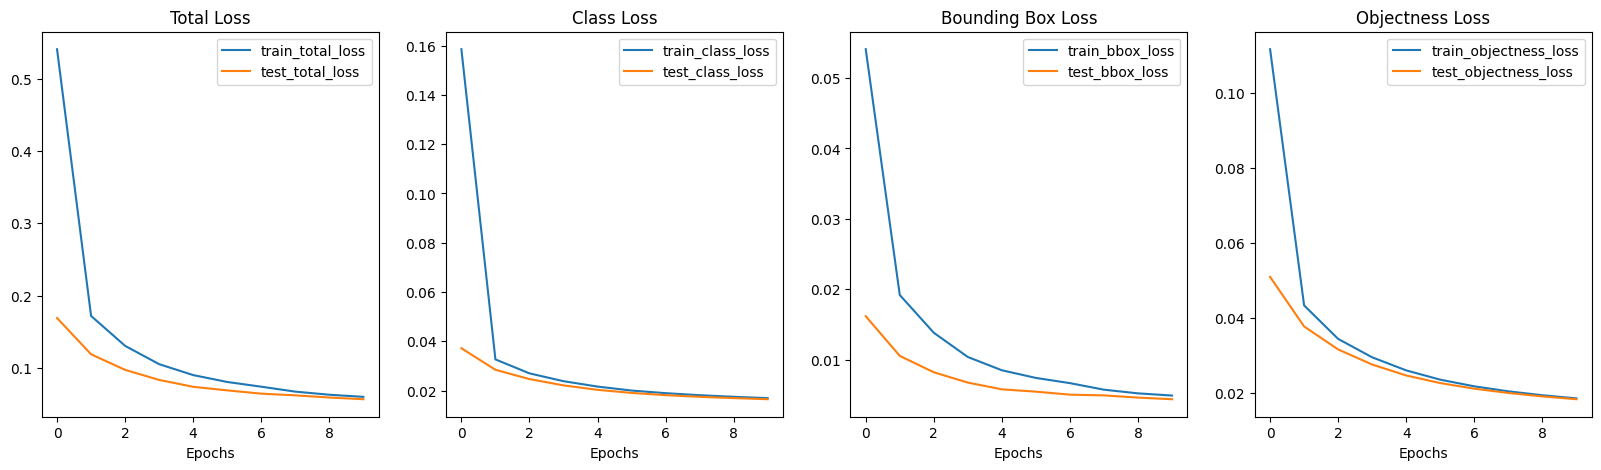

In [34]:
def plot_loss_curves(results: Dict[str, List[float]]) -> None:
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    train_total_loss = results["train_total_loss"]
    train_class_loss = results["train_class_loss"]
    train_bbox_loss = results["train_bbox_loss"]
    train_objectness_loss = results["train_objectness_loss"]
    test_total_loss = results["test_total_loss"]
    test_class_loss = results["test_class_loss"]
    test_bbox_loss = results["test_bbox_loss"]
    test_objectness_loss = results["test_objectness_loss"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_total_loss"]))

    # Setup a plot
    plt.figure(figsize=(20, 5))

    # Plot loss
    plt.subplot(1, 4, 1)
    plt.plot(epochs, train_total_loss, label="train_total_loss")
    plt.plot(epochs, test_total_loss, label="test_total_loss")
    plt.title("Total Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 4, 2)
    plt.plot(epochs, train_class_loss, label="train_class_loss")
    plt.plot(epochs, test_class_loss, label="test_class_loss")
    plt.title("Class Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs, train_bbox_loss, label="train_bbox_loss")
    plt.plot(epochs, test_bbox_loss, label="test_bbox_loss")
    plt.title("Bounding Box Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs, train_objectness_loss, label="train_objectness_loss")
    plt.plot(epochs, test_objectness_loss, label="test_objectness_loss")
    plt.title("Objectness Loss")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curves(results)

## Save Model:

In [ ]:
def save_model(model: torch.nn.Module, dir: Path, model_name: str) -> None:
    """Saves a PyTorch model to a target directory.

    Args:
      model: A target PyTorch model to save.
      target_dir: A directory for saving the model to.
      model_name: A filename for the saved model. Should include
        either ".pth" or ".pt" as the file extension.

    Example usage:
      save_model(model=model_0,
                 target_dir="models",
                 model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    dir.mkdir(parents=True, exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = dir / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)


# Save the model
save_model(detection_model, dir=Path("../models"), model_name="dinov2_object_detector.pth")

[INFO] Saving model to: ../models/dinov2_object_detector.pth


## Inference:

Image: 1361_jpg.rf.2b534ce7c445dcd461b97980223e23e4
First label Class: pituitary, ID: 2
Image size: 640 x 640
First label number of polygon vertices: 10
First label raw coordinates: [(0.259052925, 0.515320334375), (0.3259052921875, 0.6295264625), (0.3621169921875, 0.6490250703125), (0.3565459609375, 0.59888579375), (0.4150417828125, 0.5821727015625), (0.40668523749999996, 0.47353760468750006), (0.3704735375, 0.428969359375), (0.31476323125, 0.42339832812499995), (0.2701949859375, 0.45403899687499993), (0.259052925, 0.515320334375)]


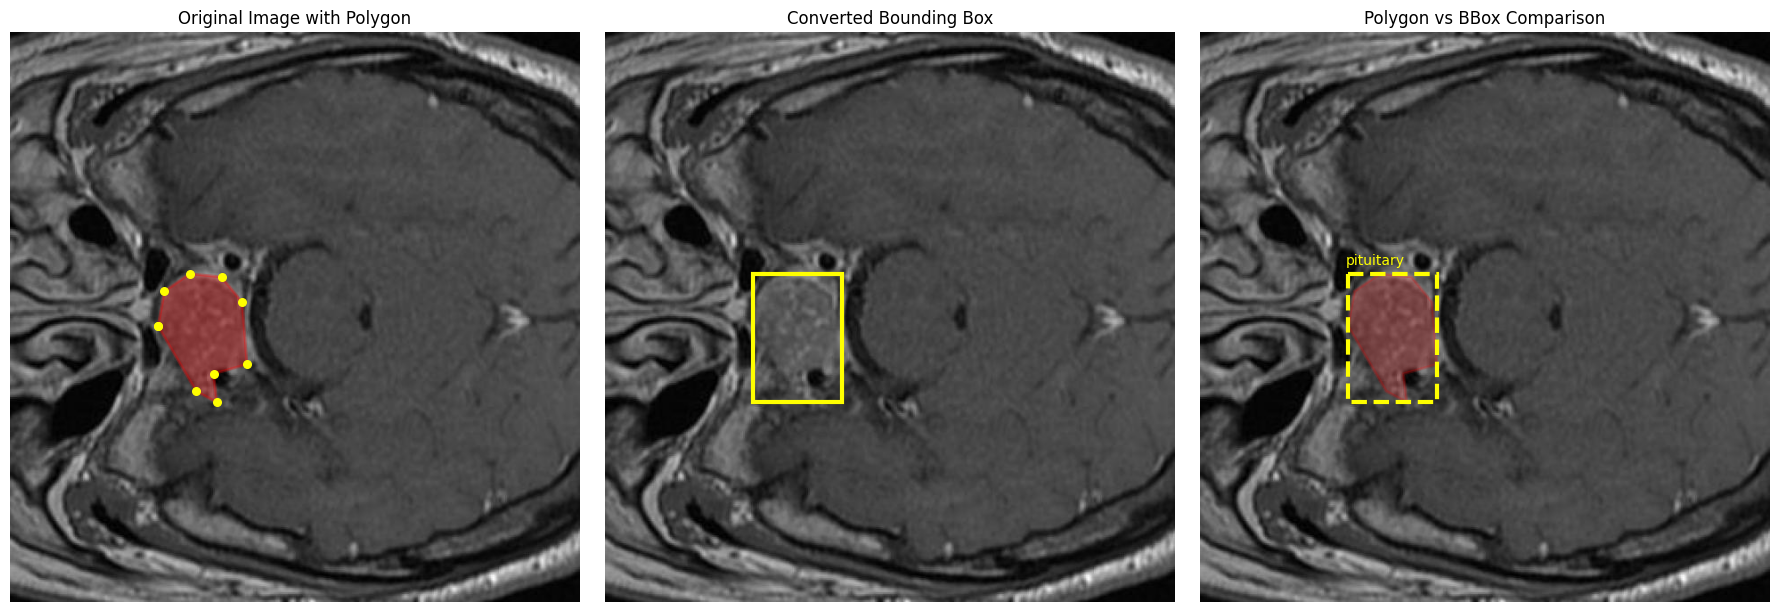

In [139]:
# Predict on validation dataset
images_path = train_path / "images"
images = list(images_path.glob("*.jpg"))
sample = random.choice(images)
image_name = sample.stem

split = "train"

visualize_polygon_vs_bbox(image_name, image_split=split)

In [140]:
detection_model.eval()
with torch.inference_mode():
    sample_image = Image.open(f"../data/BrainTumor/{split}/images/{image_name}.jpg")
    processed_image = processor(images=sample_image, return_tensors="pt")
    pixel_values = processed_image["pixel_values"].to(device)
    outputs = detection_model(pixel_values)

objectness = torch.sigmoid(outputs["objectness"].squeeze(0))
class_probs = torch.softmax(outputs["class_logits"].squeeze(0), dim=-1)
class_pred = torch.argmax(class_probs, dim=-1)
bboxes = outputs["bbox_preds"].squeeze(0)

In [141]:
objectness > 0.5

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [158]:
# class_probs[:,0] < 0.5
class_pred.shape

torch.Size([256])

In [ ]:
def debug_model_predictions(
    model: torch.nn.Module,
    image_path: Path,
    processor=processor,
    device: torch.device = device,
) -> None:
    """Debug what the model is actually predicting"""
    img = Image.open(image_path)
    model.eval()

    with torch.inference_mode():
        processed_input = processor(images=img, return_tensors="pt")
        pixel_values = processed_input["pixel_values"].to(device)
        outputs = model(pixel_values)

    # Extract outputs
    class_logits = outputs["class_logits"].squeeze(0)  # [num_patches, num_classes+1]
    bbox_preds = outputs["bbox_preds"].squeeze(0)  # [num_patches, 4]
    objectness_raw = outputs["objectness"].squeeze(0)  # [num_patches] - raw logits
    objectness_scores = torch.sigmoid(objectness_raw)  # [num_patches] - probabilities

    # Get class probabilities
    class_probs = torch.softmax(class_logits, dim=-1)  # [num_patches, num_classes+1]
    class_ids = torch.argmax(class_probs, dim=-1)  # [num_patches]
    max_class_probs = torch.max(class_probs, dim=-1)[0]  # [num_patches]

    print("=== MODEL PREDICTION DEBUG ===")
    print(
        f"Objectness scores - Min: {objectness_scores.min():.4f}, Max: {objectness_scores.max():.4f}, Mean: {objectness_scores.mean():.4f}"
    )
    print(f"Objectness raw logits - Min: {objectness_raw.min():.4f}, Max: {objectness_raw.max():.4f}")
    print(f"Class probabilities (max per patch) - Min: {max_class_probs.min():.4f}, Max: {max_class_probs.max():.4f}")
    print(
        f"Background probability - Min: {class_probs[:, 0].min():.4f}, Max: {class_probs[:, 0].max():.4f}, Mean: {class_probs[:, 0].mean():.4f}"
    )

    # Count predictions by class
    for class_id in range(4):  # 0=background, 1-3=tumor types
        count = (class_ids == class_id).sum().item()
        if class_id == 0:
            print(f"Patches predicted as BACKGROUND: {count}/256 ({count / 256 * 100:.1f}%)")
        else:
            print(f"Patches predicted as {CLASSES_NAMES[class_id - 1]}: {count}/256 ({count / 256 * 100:.1f}%)")

    # Show top objectness patches
    top_objectness_indices = torch.topk(objectness_scores, 10).indices
    print("\nTop 10 objectness scores:")
    for i, idx in enumerate(top_objectness_indices):
        obj_score = objectness_scores[idx].item()
        class_prob = max_class_probs[idx].item()
        class_id = class_ids[idx].item()
        class_name = "BACKGROUND" if class_id == 0 else CLASSES_NAMES[class_id - 1]
        print(f"  Patch {idx}: obj={obj_score:.4f}, class_conf={class_prob:.4f}, class={class_name}")


# Predict on validation dataset
images_path = valid_path / "images"
images = list(images_path.glob("*.jpg"))
sample = random.choice(images)

# Test with a sample image
print(sample.name)
debug_model_predictions(detection_model, sample)

337_jpg.rf.3077f0ce28c1826a345d48ce07ebbcd6.jpg
=== MODEL PREDICTION DEBUG ===
Objectness scores - Min: 0.0032, Max: 0.1529, Mean: 0.0063
Objectness raw logits - Min: -5.7531, Max: -1.7123
Class probabilities (max per patch) - Min: 0.7682, Max: 0.9996
Background probability - Min: 0.7682, Max: 0.9996, Mean: 0.9955
Patches predicted as BACKGROUND: 256/256 (100.0%)
Patches predicted as glioma: 0/256 (0.0%)
Patches predicted as meningioma: 0/256 (0.0%)
Patches predicted as pituitary: 0/256 (0.0%)

Top 10 objectness scores:
  Patch 99: obj=0.1529, class_conf=0.7682, class=BACKGROUND
  Patch 115: obj=0.0886, class_conf=0.8515, class=BACKGROUND
  Patch 116: obj=0.0752, class_conf=0.9002, class=BACKGROUND
  Patch 114: obj=0.0494, class_conf=0.9189, class=BACKGROUND
  Patch 97: obj=0.0479, class_conf=0.9405, class=BACKGROUND
  Patch 98: obj=0.0442, class_conf=0.9201, class=BACKGROUND
  Patch 83: obj=0.0366, class_conf=0.9740, class=BACKGROUND
  Patch 100: obj=0.0290, class_conf=0.9717, class=B

Detection method used: Emergency fallback (top objectness)
Found 3 detections
  Detection 1: BACKGROUND, conf=0.949, obj=0.165
  Detection 2: BACKGROUND, conf=0.714, obj=0.178
  Detection 3: BACKGROUND, conf=0.696, obj=0.150


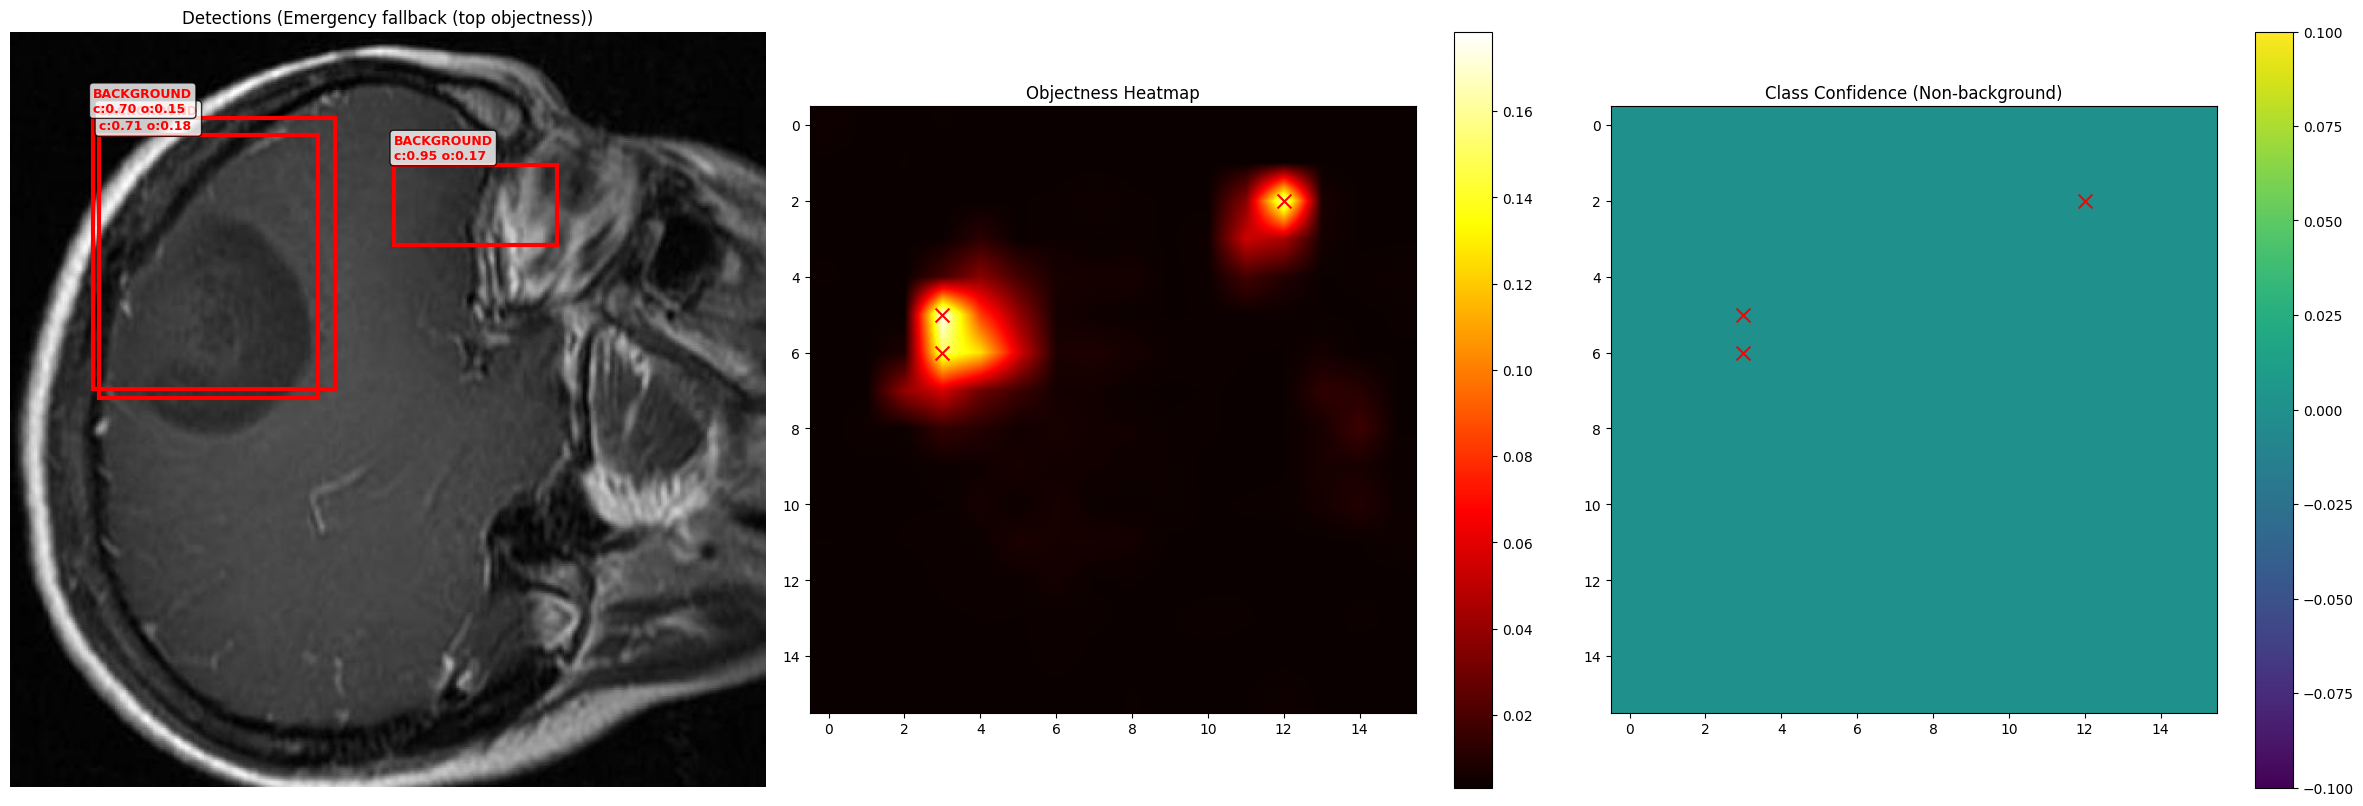

In [157]:
def pred_and_plot_image_lenient(
    model: torch.nn.Module,
    image_path: Path,
    class_names: List[str],
    processor=processor,
    device: torch.device = device,
    objectness_threshold: float = 0.1,  # Much lower threshold
    confidence_threshold: float = 0.25,  # Lower confidence threshold
    top_k_detections: int = 5,  # Show top K most confident detections
    patch_size: int = 14,
    image_size: Tuple[int, int] = (224, 224),
) -> None:
    """More lenient inference for medical imaging where recall is critical"""

    img = Image.open(image_path).convert("RGB")
    original_size = img.size
    model.eval()

    with torch.inference_mode():
        processed_input = processor(images=img, return_tensors="pt")
        pixel_values = processed_input["pixel_values"].to(device)
        outputs = model(pixel_values)

    # Extract outputs
    class_logits = outputs["class_logits"].squeeze(0)
    bbox_preds = outputs["bbox_preds"].squeeze(0).cpu()
    objectness_scores = torch.sigmoid(outputs["objectness"]).squeeze(0)

    class_probs = torch.softmax(class_logits, dim=-1)
    class_ids = torch.argmax(class_probs, dim=-1)
    max_class_probs = torch.max(class_probs, dim=-1)[0]

    patches_per_side = image_size[0] // patch_size

    # Strategy 1: Use lower thresholds
    valid_patches_conservative = (
        (objectness_scores > objectness_threshold) & (class_ids > 0) & (max_class_probs > confidence_threshold)
    )

    # Strategy 2: Take top-k most confident non-background predictions
    non_background_mask = class_ids > 0
    if non_background_mask.sum() > 0:
        non_bg_objectness = objectness_scores[non_background_mask]
        non_bg_confidence = max_class_probs[non_background_mask]
        # Combine objectness and confidence scores
        combined_scores = (non_bg_objectness + non_bg_confidence) / 2

        if len(combined_scores) >= top_k_detections:
            _, top_indices_within_non_bg = torch.topk(combined_scores, top_k_detections)
            non_bg_indices = torch.nonzero(non_background_mask).squeeze(-1)
            top_patch_indices = non_bg_indices[top_indices_within_non_bg]

            valid_patches_topk = torch.zeros_like(objectness_scores, dtype=torch.bool)
            valid_patches_topk[top_patch_indices] = True
        else:
            valid_patches_topk = non_background_mask
    else:
        valid_patches_topk = torch.zeros_like(objectness_scores, dtype=torch.bool)

    # Use the method that gives more detections
    if valid_patches_conservative.sum() > 0:
        valid_patches = valid_patches_conservative
        method_used = "Conservative thresholding"
    elif valid_patches_topk.sum() > 0:
        valid_patches = valid_patches_topk
        method_used = f"Top-{top_k_detections} detections"
    else:
        # Emergency fallback: show top 3 objectness scores regardless of class
        _, top_obj_indices = torch.topk(objectness_scores, 3)
        valid_patches = torch.zeros_like(objectness_scores, dtype=torch.bool)
        valid_patches[top_obj_indices] = True
        method_used = "Emergency fallback (top objectness)"

    print(f"Detection method used: {method_used}")
    print(f"Found {valid_patches.sum()} detections")

    if valid_patches.sum() == 0:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title("No objects detected")
        plt.axis("off")
        plt.show()
        return

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Plot 1: Original image with detections
    ax1 = axes[0]
    ax1.imshow(img)
    ax1.set_title(f"Detections ({method_used})")
    ax1.axis("off")

    # Plot 2: Objectness heatmap
    ax2 = axes[1]
    objectness_map = objectness_scores.cpu().numpy().reshape(patches_per_side, patches_per_side)
    im2 = ax2.imshow(objectness_map, cmap="hot", interpolation="bilinear")
    ax2.set_title("Objectness Heatmap")
    plt.colorbar(im2, ax=ax2)

    # Plot 3: Class confidence heatmap (max non-background confidence)
    ax3 = axes[2]
    class_conf_map = torch.where(class_ids > 0, max_class_probs, torch.zeros_like(max_class_probs))
    class_conf_np = class_conf_map.cpu().numpy().reshape(patches_per_side, patches_per_side)
    im3 = ax3.imshow(class_conf_np, cmap="viridis", interpolation="bilinear")
    ax3.set_title("Class Confidence (Non-background)")
    plt.colorbar(im3, ax=ax3)

    colors = ["red", "blue", "green", "yellow", "purple", "orange"]

    # Draw detections
    for i, patch_idx in enumerate(torch.nonzero(valid_patches).squeeze(-1).cpu()):
        patch_y = patch_idx // patches_per_side
        patch_x = patch_idx % patches_per_side

        cx, cy, w, h = bbox_preds[patch_idx]

        # Convert to pixel coordinates
        cx_pixel = cx * original_size[0]
        cy_pixel = cy * original_size[1]
        w_pixel = w * original_size[0]
        h_pixel = h * original_size[1]

        x_min = cx_pixel - w_pixel / 2
        y_min = cy_pixel - h_pixel / 2

        class_id = class_ids[patch_idx].item()
        class_name = "BACKGROUND" if class_id == 0 else class_names[class_id - 1]
        confidence = max_class_probs[patch_idx].item()
        objectness = objectness_scores[patch_idx].item()

        print(f"  Detection {i + 1}: {class_name}, conf={confidence:.3f}, obj={objectness:.3f}")

        color = colors[class_id % len(colors)]
        rect = patches.Rectangle((x_min, y_min), w_pixel, h_pixel, linewidth=3, edgecolor=color, facecolor="none")
        ax1.add_patch(rect)

        label_text = f"{class_name}\nc:{confidence:.2f} o:{objectness:.2f}"
        ax1.text(
            x_min,
            y_min - 5,
            label_text,
            color=color,
            fontsize=9,
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

        # Mark patches on heatmaps
        ax2.scatter(patch_x, patch_y, c=color, s=100, marker="x")
        ax3.scatter(patch_x, patch_y, c=color, s=100, marker="x")

    plt.tight_layout()
    plt.show()


# Test the lenient version
pred_and_plot_image_lenient(
    model=detection_model,
    image_path=Path("../data/BrainTumor/valid/images/2922_jpg.rf.b253cf67318f024dbbfe882babd3a13c.jpg"),
    class_names=CLASSES_NAMES,
    objectness_threshold=0.05,  # Very low threshold
    confidence_threshold=0.2,  # Low confidence threshold
    top_k_detections=3,
)